In [64]:
import numpy as np
import numba
import cv2
import time

@numba.njit
def bilinear_interpolation_gpu(image, output_shape):
    src_h, src_w = image.shape[:2]
    dst_h, dst_w = output_shape[:2]

    sh = src_h / dst_h
    sw = src_w / dst_w

    output_image = np.zeros(output_shape, dtype=np.float32)

    for i in range(dst_h):
        for j in range(dst_w):

            y = i * sh
            x = j * sw

            y_int = int(y)
            x_int = int(x)

            y_frac = y - y_int
            x_frac = x - x_int

            y_int_next = min(y_int + 1, src_h - 1)
            x_int_next = min(x_int + 1, src_w - 1)

            output_image[i, j] = (
                (1 - x_frac) * (1 - y_frac) * image[y_int, x_int] +
                (1 - x_frac) * y_frac * image[y_int_next, x_int] +
                x_frac * (1 - y_frac) * image[y_int, x_int_next] +
                x_frac * y_frac * image[y_int_next, x_int_next]
            )

    return output_image


def bilinear_interpolation_cpu(image, new_size):
    height, width = image.shape[:2]
    new_height, new_width = new_size
    scale_x = float(width) / new_width
    scale_y = float(height) / new_height
    interpolation_image = np.zeros((new_height, new_width, image.shape[2]), dtype=np.uint8)

    for y in range(new_height):
        for x in range(new_width):
            src_x = (x + 0.5) * scale_x - 0.5
            src_y = (y + 0.5) * scale_y - 0.5

            x0 = int(np.floor(src_x))
            x1 = min(x0 + 1, width - 1)
            y0 = int(np.floor(src_y))
            y1 = min(y0 + 1, height - 1)

            dx = src_x - x0
            dy = src_y - y0

            interpolation_image[y, x] = (1 - dx) * (1 - dy) * image[y0, x0] \
                                        + dx * (1 - dy) * image[y0, x1] \
                                        + (1 - dx) * dy * image[y1, x0] \
                                        + dx * dy * image[y1, x1]
    return interpolation_image

def cpu(image, interpolation, resize_coef, iteration):
    times = []
    sizes = []
    for i in range(iteration):
        size = (image.shape[0] * resize_coef, image.shape[1] * resize_coef)
        start = time.time()
        interpolation_image = interpolation(cv2.resize(image, size), size)
        end = time.time()
        times.append((end - start))
        resize_coef = resize_coef + 1
        sizes.append(size)

    return times, sizes

iteration = 100
resize_coef = 2

print("Размеры входной картинки: ", cv2.imread('picture.bmp').shape[0], cv2.imread('picture.bmp').shape[1])
times_cpu, sizes = cpu(cv2.imread('picture.bmp'), bilinear_interpolation_cpu, resize_coef, iteration)

times_gpu, _ = cpu(cv2.imread('picture.bmp', cv2.IMREAD_GRAYSCALE), bilinear_interpolation_gpu, resize_coef, iteration)

sizes = [size for size, _ in sizes]

print("Затраченное время CPU: ", sum(times_cpu))
print("Затраченное вермя GPU: ", sum(times_gpu))
print("Time cpu/gpu", sum(times_cpu)/sum(times_gpu))

Размеры входной картинки:  12 12
Затраченное время CPU:  620.5518720149994
Затраченное вермя GPU:  0.6217339038848877
Time cpu/gpu 998.0988138776052


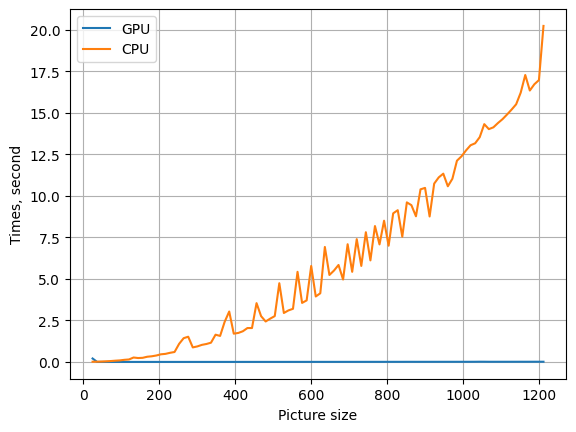

In [65]:
import matplotlib.pyplot as plt

plt.plot(sizes, times_gpu, label = 'GPU')
plt.plot(sizes, times_cpu, label = 'CPU')
plt.xlabel("Picture size")
plt.ylabel("Times, second")
plt.legend()
plt.grid()
plt.show()

![image.png](pictures/interp.bmp) - исходная картинка

![image.png](pictures/restinterp.bmp) - результат
